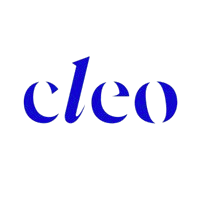

### **Parcours Makers - Module 1 - Prompt engineering avancé**
##**Cours 1 : Implémenter un raisonnement Chain-of-Thought pas à pas avec Self-Refine**

Ce notebook vous guide étape par étape pour structurer un raisonnement explicite en Python avec un LLM (modèle de langage). Vous apprendrez à :

- Construire un prompt clair qui guide le raisonnement du modèle
- Récupérer une réponse structurée
- Déclencher une relecture automatique (Self-Refine) pour corriger et améliorer la réponse
- Comparer les deux versions selon des critères simples

## 1. Préparation de l’environnement

Commencez par installer les dépendances nécessaires (OpenAI, gestion de variables d’environnement, encodage).

In [ ]:
# ⬇️ Exécutez cette cellule une seule fois
# exécutez une seule fois
!pip install -q \
    openai==1.96.1 \
    python-dotenv==1.1.1 \
    tiktoken==0.9.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 757.5/757.5 kB 12.2 MB/s eta 0:00:00


In [ ]:
import os
from getpass import getpass
from dotenv import load_dotenv

load_dotenv()                              # charge un éventuel .env
if "OPENAI_API_KEY" not in os.environ:     # invite si la variable manque
    os.environ["OPENAI_API_KEY"] = getpass("🔑 Entrer votre clé OpenAI : ")


🔑 Entrer votre clé OpenAI : ··········


In [ ]:
from openai import OpenAI
client = OpenAI()  # le client utilisera directement la variable d'environnement

## 2. Créer un prompt Chain-of-Thought

Nous composons un prompt en trois parties :

- Rôle : précise la posture du modèle.
- Consigne : détaille la tâche et impose un raisonnement explicite.
- Format : indique comment structurer les étapes et la conclusion.


In [ ]:
def create_cot_prompt(question: str) -> str:
    """Construit un prompt explicite en trois sections."""
    return f"""
Tu es un consultant expert en organisation.
Ta tâche : répondre à la question ci-dessous en détaillant ton raisonnement étape par étape.
Pour chaque étape, commence par 'Étape :' puis termine par 'Conclusion :' sur une ligne à part.

Question : {question}
""".strip()


## 3. Générer une première réponse (version 1)

Le modèle est appelé avec une température basse pour privilégier la cohérence.

In [ ]:
def ask_openai(prompt: str, model="gpt-4o-mini", temperature=0.3):
    response = client.chat.completions.create(
        model=model,
        temperature=temperature,
        messages=[{"role": "user", "content": prompt}],
    )
    return response.choices[0].message.content


In [ ]:
# Exemple : question métier
question = (
    "Comment estimer le budget annuel nécessaire pour déployer un CRM "
    "dans une PME de 100 utilisateurs, en tenant compte des licences, "
    "de la formation et de la maintenance ?"
)

prompt_v1 = create_cot_prompt(question)
answer_v1 = ask_openai(prompt_v1)
print("🔹 Réponse initiale (v1)\n")
print(answer_v1)


🔹 Réponse initiale (v1)

Étape : Identifier les besoins spécifiques de la PME en matière de CRM. Cela inclut la définition des fonctionnalités requises (gestion des contacts, automatisation des ventes, reporting, etc.) et l'évaluation des processus métiers existants. Une bonne compréhension des besoins permettra de choisir un CRM adapté et d'estimer les coûts associés.

Conclusion :

Étape : Rechercher les différentes options de CRM disponibles sur le marché. Il existe plusieurs types de CRM, allant des solutions cloud aux logiciels sur site. Il est important de comparer les prix des licences, qui peuvent varier considérablement en fonction des fonctionnalités et du nombre d'utilisateurs.

Conclusion :

Étape : Estimer le coût des licences. Pour une PME de 100 utilisateurs, il faut multiplier le coût par utilisateur par le nombre total d'utilisateurs. Par exemple, si le coût est de 30 € par utilisateur par mois, le coût annuel serait de 30 € x 100 utilisateurs x 12 mois = 36 000 €.

Co

## 4. Créer un prompt Self-Refine

Le modèle relit sa propre réponse, détecte les incohérences ou lacunes, puis produit une version révisée.
Nous conservons la même question et insérons la réponse v1 dans un nouveau prompt critique.

In [ ]:
def create_self_refine_prompt(question: str, first_answer: str) -> str:
    return f"""
Tu es le même consultant, mais tu dois maintenant relire ta réponse.
Identifie toute erreur, toute ambiguïté ou tout manque de précision,
puis propose une version améliorée. Utilise le format :

Analyse :
- (liste de points à corriger)

Réponse révisée :
- Étape 1 :
- Étape 2 :
...
- Conclusion :

Question : {question}

Ta réponse initiale :
{first_answer}
""".strip()

In [ ]:
prompt_v2 = create_self_refine_prompt(question, answer_v1)
answer_v2 = ask_openai(prompt_v2)
print("🔹 Réponse révisée (v2)\n")
print(answer_v2)


🔹 Réponse révisée (v2)

Analyse :
- La réponse initiale manque de structure et de clarté, car chaque étape est suivie d'une "conclusion" qui n'apporte pas de valeur ajoutée.
- Certaines étapes pourraient être regroupées pour éviter des répétitions inutiles.
- Les exemples chiffrés sont utiles, mais il serait préférable de les présenter de manière plus cohérente.
- Il manque une introduction qui contextualise la réponse.
- La conclusion finale pourrait être plus synthétique et explicative.

Réponse révisée :
- Introduction : Pour estimer le budget annuel nécessaire à la mise en place d'un CRM dans une PME de 100 utilisateurs, il est essentiel de considérer plusieurs éléments clés, notamment les licences, la formation, la maintenance et une marge pour les imprévus.

- Étape 1 : Identifier les besoins spécifiques de la PME en matière de CRM. Cela inclut la définition des fonctionnalités requises (gestion des contacts, automatisation des ventes, reporting, etc.) et l'évaluation des process

## 5. Comparer les deux versions

Nous effectuons une comparaison simple : longueur (tokens), nombre d’étapes et clarté perçue.
Vous pouvez compléter avec vos propres critères.

In [ ]:
import tiktoken, textwrap, re

enc = tiktoken.encoding_for_model("gpt-4o-mini")

def count_tokens(text):
    return len(enc.encode(text))

def count_steps(text):
    return len(re.findall(r"Étape\s*\d*", text, flags=re.IGNORECASE))

def summary_stats(label, text):
    print(f"{label}\nTokens : {count_tokens(text)} | Étapes : {count_steps(text)}\n")

In [ ]:
summary_stats("Version 1", answer_v1)
summary_stats("Version 2", answer_v2)

print("─"*60)
print("A vous d'évaluer maintenant la clarté et la cohérence de chaque version.")

Version 1
Tokens : 625 | Étapes : 8

Version 2
Tokens : 787 | Étapes : 9

────────────────────────────────────────────────────────────
A vous d'évaluer maintenant la clarté et la cohérence de chaque version.


## 6. Activité guidée

1. Dans la cellule suivante, remplacez la variable question par votre propre question métier.

2. Réexécutez l’ensemble des cellules depuis la création du prompt pour observer le raisonnement et la version Self-Refine.

3. Notez les écarts entre v1 et v2 :
  - Les étapes sont-elles plus détaillées ?
  - La conclusion est-elle plus précise ?
  - La structure respecte-t-elle le format attendu ?


In [ ]:
# 🔄 Personnalisez ici votre question, puis relancez tout
question = "Définis un plan de migration vers le cloud pour une startup SaaS de 50 personnes."

In [ ]:
prompt_v1 = create_cot_prompt(question)
answer_v1 = ask_openai(prompt_v1)
print("🔹 Réponse initiale (v1)\n")
print(answer_v1)


🔹 Réponse initiale (v1)

Étape 1 : Évaluation des besoins et des objectifs
Dans cette première étape, il est crucial de comprendre les besoins spécifiques de la startup SaaS. Il faut identifier les applications et les services qui seront migrés vers le cloud, ainsi que les objectifs de cette migration (réduction des coûts, scalabilité, sécurité, etc.). Une analyse des performances actuelles et des limitations des infrastructures existantes doit également être réalisée.

Conclusion : Une évaluation approfondie des besoins et des objectifs permettra de définir une stratégie de migration adaptée à la startup.

Étape 2 : Sélection du modèle de cloud
Il existe plusieurs modèles de cloud (public, privé, hybride). Il est essentiel de choisir celui qui correspond le mieux aux besoins de la startup. Par exemple, un cloud public peut être plus économique pour des applications non sensibles, tandis qu'un cloud privé peut être nécessaire pour des données sensibles ou des exigences de conformité.



In [ ]:
prompt_v2 = create_self_refine_prompt(question, answer_v1)
answer_v2 = ask_openai(prompt_v2)
print("🔹 Réponse révisée (v2)\n")
print(answer_v2)

🔹 Réponse révisée (v2)

Analyse :
- La réponse initiale présente une structure claire, mais elle manque de précision dans certains domaines, notamment sur les critères de sélection des fournisseurs et les détails de la mise en œuvre de la sécurité.
- Les conclusions à la fin de chaque étape sont redondantes et pourraient être consolidées pour éviter la répétition.
- Certaines étapes pourraient bénéficier d'exemples concrets ou de recommandations spécifiques pour renforcer la pertinence.
- L'ordre des étapes pourrait être légèrement ajusté pour mieux refléter le processus de migration.

Réponse révisée :
- Étape 1 : Évaluation des besoins et des objectifs
  - Identifier les applications et services à migrer.
  - Définir les objectifs de la migration (réduction des coûts, scalabilité, sécurité, etc.).
  - Réaliser une analyse des performances actuelles et des limitations des infrastructures existantes.

- Étape 2 : Sélection du modèle de cloud
  - Évaluer les différents modèles de cloud 

In [ ]:
summary_stats("Version 1", answer_v1)
summary_stats("Version 2", answer_v2)

Version 1
Tokens : 807 | Étapes : 13

Version 2
Tokens : 684 | Étapes : 15



## Pour aller plus loin

- Testez la même boucle avec différents modèles (gpt-4o, o3) et comparez coûts et qualités.
- Expérimentez avec des paramètres temperature et top_p plus élevés pour observer l’impact sur la créativité et la longueur des réponses.
- Ajoutez un compteur de tentatives Self-Refine pour arrêter la boucle si le modèle n’améliore plus son texte.
- Intégrer un score de qualité : demander au modèle de s’autoévaluer, ou intégrer une métrique externe pour noter la qualité de chaque réponse. Cela permet d’industrialiser la boucle Self-Refine.



## Conclusion

Vous disposez maintenant d’un socle simple pour générer un raisonnement pas à pas et le faire relire par le modèle lui-même. Cette technique améliore la transparence et la fiabilité des réponses, tout en restant accessible à un public non technique. Adaptez-la à vos propres cas d’usage pour renforcer la qualité des livrables générés par un LLM.